# lambda cdm

In [46]:
from classy import Class
import numpy as np
LambdaCDM = Class()
# 1807.06209 table 2, TT,TE,EE+lowE+lensing 
LambdaCDM.set({'omega_b':0.02237,
               'omega_cdm':0.1200,
            #    '100theta_s':1.04110,
               'H0':67.36,
               'ln10^{10}A_s':3.044,
               'n_s':0.9649,
               'tau_reio':0.0544,
               'N_mscf':0,
               "do_shooting": "no",
               }
               )

# https://hal.science/hal-04231374/file/aa48015-23.pdf
# LambdaCDM.set({'omega_b':0.02226,
#                'omega_cdm':0.1188,
#             #    '100theta_s':1.04110,
#                'H0':67.64,
#                'ln10^{10}A_s':3.040,
#                'n_s':0.9681,
#                'tau_reio':0.0580,
#                'N_mscf':0,
#                "do_shooting": "no",
#                }
#                )



LambdaCDM.set({'output':'tCl,pCl,lCl,mPk','lensing':'yes'})

LambdaCDM.compute()
bg = LambdaCDM.get_background()


cl_tot_0 = LambdaCDM.lensed_cl(2500)

ell = cl_tot_0['ell']
cl_tt_0 = cl_tot_0['tt']
T_cmb = 2.725
T_uK = T_cmb*1e6
D_ell_0 = ell*(ell+1)/(2*np.pi) * cl_tt_0 * T_uK**2
z_lcdm = bg['z'] #redshift
H_lcdm = bg['H [1/Mpc]'] #hubble rate

NPTS = 500  # choose 100, 200, 300… depending on how small you want the file

idx = np.round(np.linspace(0, len(z_lcdm) - 1, NPTS)).astype(int)

z_small_lcdm       = z_lcdm[idx]
H_small_lcdm  = H_lcdm[idx]
print(ell)

[   0    1    2 ... 2498 2499 2500]


In [47]:
error_planck_dir = "/Users/bellamarco01/uni/1_master_thesis/error_Planck"
datasets = ['Planck2018_errorTT.txt','Planck2018_errorTE.txt','Planck2018_errorEE.txt']
import numpy as np
import matplotlib.pyplot as plt
import os

# directory and file
error_planck_dir = "/Users/bellamarco01/uni/1_master_thesis/error_Planck"
tt_file = datasets[0]
tt_path = os.path.join(error_planck_dir, tt_file)

# load data (skips lines starting with # automatically)
data = np.loadtxt(tt_path)

# columns
ell_data = data[:, 0]
Dl = data[:, 1]
Dl_err_minus = data[:, 2]
Dl_err_plus = data[:, 3]

# symmetric error (they are equal here anyway)
Dl_err = Dl_err_plus


from scipy.interpolate import interp1d


# create bins 
ell_c = ell_data
edges = np.zeros(len(ell_c) + 1)

# interior edges = midpoints
edges[1:-1] = 0.5 * (ell_c[1:] + ell_c[:-1])

# first edge (extrapolate)
edges[0] = ell_c[0] - (edges[1] - ell_c[0])

# last edge (extrapolate)
edges[-1] = ell_c[-1] + (ell_c[-1] - edges[-2])

print(edges)

from scipy.interpolate import interp1d

# build interpolator
Dl_0_interp = interp1d(
    ell,
    D_ell_0,
    kind='linear',
    bounds_error=False,
    fill_value='extrapolate'
)
from scipy.integrate import quad

def bin_integrated(Dl, lmin, lmax):
    val, _ = quad(Dl, lmin, lmax)
    return val / (lmax - lmin)

# Dl_binned_0 = np.array([
#     bin_integrated(Dl_0_interp, edges[i], edges[i+1])
#     for i in range(len(ell_c))
# ])
# residuals = (Dl_binned_0 - Dl )/ Dl_binned_0

# evaluate at Planck ell's
Dl_0_small = Dl_0_interp(ell_data)

residuals = (Dl_0_small - Dl )/ Dl_0_small


[  33.33103275   62.09141525   91.19449575  120.7613665   150.5054725
  180.3362335   210.2159075   240.1259265   270.056078    300.000276
  329.9546655   359.9166855   389.8845675   419.85705     449.83321
  479.812356    509.7939605   539.7776125   569.762987    599.749826
  629.7379205   659.7270985   689.7172185   719.7081625   749.6998315
  779.6921415   809.6850215   839.678411    869.6722565   899.6665125
  929.6611395   959.656102    989.6513715  1019.64692    1049.64272
 1079.638755   1109.635005   1139.63145    1169.628075   1199.62487
 1229.621825   1259.618925   1289.61616    1319.61352    1349.610995
 1379.60858    1409.60627    1439.604055   1469.60193    1499.599895
 1529.59794    1559.596055   1589.59424    1619.592495   1649.590815
 1679.58919    1709.587625   1739.586115   1769.584655   1799.583245
 1829.58188    1859.58056    1889.57928    1919.57804    1949.57684
 1979.575675   2009.574545   2039.57345    2069.572385   2099.57135
 2129.570345   2159.56937    2189.56

# multi-axion

In [48]:
# call this from terminal to sync
# rsync -avz --progress bella@lupm-slurm.lupm.in2p3.fr:/home/bella/mini_reconstruction_tool ~/uni/1_master_thesis/tools/output_remote


import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path


def extract_residuals(dir):
    # -----------------------------
    # ️ Loop over samples and collect data
    # -----------------------------
    npz_files = sorted(dir.glob("*_sample_*.npz"))
    all_z = []
    all_fEDE = []
    all_H =[]
    all_ell = []
    all_cl_tt = []
    weights = []

    for npz_file in npz_files:
        data = np.load(npz_file)
        all_z.append(data["z"])
        all_fEDE.append(data["f_EDE"])
        all_H.append(data["H"])
        all_ell.append(data["ell"])
        all_cl_tt.append(data["cl_tt"])
        weights.append(data["weight"])

    weights=np.array(weights)

    # Convert lists to arrays
    ell = all_ell[0]  # assume same ell grid for all samples
    print(ell)

    # shape: (n_samples, n_ell)
    T_cmb = 2.725
    T_uK = T_cmb*1e6
    D_tt_all = np.array([
        ell*(ell+1)*cl/(2*np.pi)* T_uK**2 for cl in all_cl_tt
    ])

    residuals = (D_tt_all - D_ell_0 )/ D_ell_0

    n_samples, n_ell = residuals.shape
    # weights = np.ones(n_samples)   # or real MCMC weights

    # lower_68 = np.percentile(residuals, 16, axis=0)
    # upper_68 = np.percentile(residuals, 84, axis=0)
    # lower_95 = np.percentile(residuals, 2.5, axis=0) 
    # upper_95 = np.percentile(residuals, 97.5, axis=0)
    lower_68 = np.zeros(n_ell)
    upper_68 = np.zeros(n_ell)
    lower_95 = np.zeros(n_ell)
    upper_95 = np.zeros(n_ell)

    for j in range(n_ell):
        vals = residuals[:, j]

        lower_68[j], upper_68[j] = weighted_percentile(
            vals, weights, [16, 84]
        )
        lower_95[j], upper_95[j] = weighted_percentile(
            vals, weights, [2.5, 97.5]
        )
    return lower_95, lower_68, upper_68, upper_95

def weighted_percentile(values, weights, percentiles):
    """
    values: (N_samples,)
    weights: (N_samples,)
    percentiles: list or array in [0, 100]
    """
    sorter = np.argsort(values)
    values = values[sorter]
    weights = weights[sorter]

    cdf = np.cumsum(weights)
    cdf /= cdf[-1]

    return np.interp(np.array(percentiles) / 100.0, cdf, values)


def extract_bf(bf_file):
    bf_z = []
    bf_fEDE = []
    bf_H =[]
    bf_ell = []
    bf_cl_tt = []

    data = np.load(str(bf_file))
    bf_z= (data["z"])
    bf_fEDE= (data["f_EDE"])
    bf_H= (data["H"])
    bf_ell= (data["ell"])
    bf_cl_tt= (data["cl_tt"])
    D_tt_bf = np.array(bf_ell*(bf_ell+1)*bf_cl_tt/(2*np.pi))
    residuals_bf = (bf_cl_tt - cl_tt_0 )/ cl_tt_0  # ΔD_ell = sample - LCDM
    residuals_bf_H = (bf_H - H_small_lcdm )/ H_small_lcdm  # ΔD_ell = sample - LCDM
    return residuals_bf, residuals_bf_H, bf_fEDE, bf_z

def extract_bg(dir):
    # -----------------------------
    # ️ Loop over samples and collect data
    # -----------------------------
    all_z = []
    all_fEDE = []
    all_H =[]
    all_ell = []
    all_cl_tt = []
    weights = []
    npz_files = sorted(dir.glob("*_sample_*.npz"))

    for npz_file in npz_files:
        data = np.load(npz_file)
        all_z.append(data["z"])
        all_fEDE.append(data["f_EDE"])
        all_H.append(data["H"])
        all_ell.append(data["ell"])
        all_cl_tt.append(data["cl_tt"])
        weights.append(data["weight"])

    all_fEDE = np.array(all_fEDE)      # shape: (N_samples, N_z)
    all_H = np.array(all_H)      # shape: (N_samples, N_z)
    weights = np.array(weights)
    # weights = np.ones(n_samples)   # or real MCMC weights

    # lower_68 = np.percentile(residuals, 16, axis=0)
    # upper_68 = np.percentile(residuals, 84, axis=0)
    # lower_95 = np.percentile(residuals, 2.5, axis=0) 
    # upper_95 = np.percentile(residuals, 97.5, axis=0)
    lower_68 = np.zeros(all_fEDE.shape[1])
    upper_68 = np.zeros_like(lower_68)
    lower_95 = np.zeros_like(lower_68)
    upper_95 = np.zeros_like(lower_68)
    for j in range(all_fEDE.shape[1]):
        vals = all_fEDE[:, j]
        w = weights

        lower_68[j], upper_68[j] = weighted_percentile(vals, w, [16, 84])
        lower_95[j], upper_95[j] = weighted_percentile(vals, w, [2.5, 97.5])

    lower_68_H = np.zeros(all_H.shape[1])
    upper_68_H = np.zeros_like(lower_68)
    lower_95_H = np.zeros_like(lower_68)
    upper_95_H = np.zeros_like(lower_68)

    for j in range(all_H.shape[1]):  # loop over z
        vals = (all_H[:, j] - H_small_lcdm[j])/H_small_lcdm[j]
        w = weights

        lower_68_H[j], upper_68_H[j] = weighted_percentile(vals, w, [16, 84])
        lower_95_H[j], upper_95_H[j] = weighted_percentile(vals, w, [2.5, 97.5])
    return all_z, [lower_95, lower_68, upper_68, upper_95], [lower_95_H, lower_68_H, upper_68_H, upper_95_H]

def bf_vs_planck(bf_file):
    bf_z = []
    bf_fEDE = []
    bf_H =[]
    bf_ell = []
    bf_cl_tt = []

    data = np.load(str(bf_file))
    bf_ell= (data["ell"])
    bf_cl_tt= (data["cl_tt"])
    D_tt_bf = np.array(bf_ell*(bf_ell+1)*bf_cl_tt/(2*np.pi))*T_uK**2

    from scipy.interpolate import interp1d

    # build interpolator
    D_tt_interp = interp1d(
        ell,
        D_tt_bf,
        kind='linear',
        bounds_error=False,
        fill_value='extrapolate'
    )

    # Dl_binned = np.array([
    #     bin_integrated(D_tt_interp, edges[i], edges[i+1])
    #     for i in range(len(ell_c))
    # ])
    # residuals = (Dl_binned - Dl )/ Dl_binned_0

    # evaluate at Planck ell's
    Dl_small = D_tt_interp(ell_data)

    residuals = (Dl_small - Dl )


    # D_tt_small = D_tt_interp(ell_data)

    return residuals


In [61]:
# -----------------------------
#1pd
# -----------------------------
data_dirs = ["/Users/bellamarco01/uni/1_master_thesis/tools/output_remote/mini_reconstruction_tool/1pd/output_class/", 
             "/Users/bellamarco01/uni/1_master_thesis/tools/output_remote/mini_reconstruction_tool/1psd/output_class/",
             "/Users/bellamarco01/uni/1_master_thesis/tools/output_remote/mini_reconstruction_tool/2pd/output_class/", 
             "/Users/bellamarco01/uni/1_master_thesis/tools/output_remote/mini_reconstruction_tool/2psd/output_class/"]

residuals_bf_all = []
bf_vs_planck_all = []
lower_95_all = []
upper_95_all = []
lower_68_all = []
upper_68_all = []
ci_h_all = []
ci_fede_all =[]
zd_all = []
residuals_bf_H_all = []
f_ede_all = []
z_bf_all = []
for data_dir in data_dirs:
    dir = Path(data_dir)
    bf_file = data_dir + "bestfit.npz"
    
    lower_95, lower_68, upper_68, upper_95 = extract_residuals(dir)
    zd, ci_fede, ci_h = extract_bg(dir)
    residuals_bf, residuals_bf_H, f_ede, z_bf = extract_bf(bf_file)
    res_vs_planck = bf_vs_planck(bf_file)
    
    # append everything
    residuals_bf_all.append(residuals_bf)
    residuals_bf_H_all.append(residuals_bf_H)
    f_ede_all.append(f_ede)
    z_bf_all.append(z_bf)
    bf_vs_planck_all.append(res_vs_planck)
    lower_95_all.append(lower_95)
    upper_95_all.append(upper_95)
    lower_68_all.append(lower_68)
    upper_68_all.append(upper_68)
    zd_all.append(zd)
    ci_h_all.append(ci_h)
    ci_fede_all.append(ci_fede)


[   0    1    2 ... 2498 2499 2500]


/var/folders/ds/l5tt9lyx5pl1c9t1ytlzxb7w0000gn/T/ipykernel_21410/2352827757.py:44: RuntimeWarning: invalid value encountered in divide
  residuals = (D_tt_all - D_ell_0 )/ D_ell_0
/var/folders/ds/l5tt9lyx5pl1c9t1ytlzxb7w0000gn/T/ipykernel_21410/2352827757.py:99: RuntimeWarning: invalid value encountered in divide
  residuals_bf = (bf_cl_tt - cl_tt_0 )/ cl_tt_0  # ΔD_ell = sample - LCDM


[   0    1    2 ... 2498 2499 2500]
[   0    1    2 ... 2498 2499 2500]
[   0    1    2 ... 2498 2499 2500]


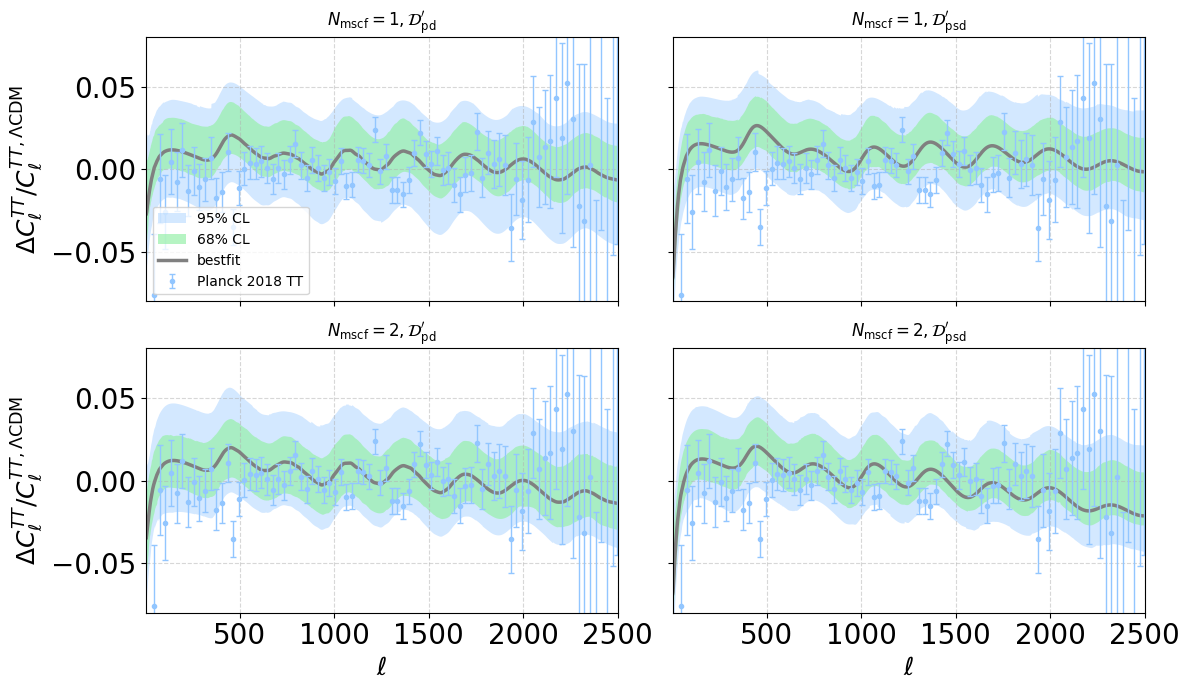

Saved residuals.pdf to /Users/bellamarco01/uni/1_master_thesis/thesis/plots


In [50]:
import plotting.plotting as pl

fig,axs = pl.new_fig(figsize=[12,7],nrows=2,ncols=2)

names = [r'$N_\text{mscf}=1, \mathcal{D}^\prime_\text{pd}$',r'$N_\text{mscf}=1, \mathcal{D}^\prime_\text{psd}$',r'$N_\text{mscf}=2, \mathcal{D}^\prime_\text{pd}$',r'$N_\text{mscf}=2, \mathcal{D}^\prime_\text{psd}$',]

for i in [0,1,2,3]:
    residuals_bf = residuals_bf_all[i]
    lower_95 = lower_95_all[i]
    upper_95 = upper_95_all[i]
    lower_68 = lower_68_all[i]
    upper_68 = upper_68_all[i]
    ax = axs[i]


    ax.fill_between(
    ell, lower_95, upper_95,
    alpha=0.4, label="95% CL"
    )

    ax.fill_between(
    ell, lower_68, upper_68,
    alpha=0.7, label="68% CL"
    )
    ax.plot(ell, residuals_bf, linewidth=2.5, label='bestfit',color='grey')

    # plt.xlabel(r"$\ell$")
    # plt.ylabel(r"$D_\ell^{TT}$ [$\mu K^2$]")
    ax.set_title(names[i])
    ax.set_xlim(2, 2500)
    # plt.ylim(0,0.1)
    ax.ticklabel_format(style='plain', axis='both')
    ax.get_xaxis().get_major_formatter().set_useOffset(False)
    # ax.set_ylim(-1.5,-.5)
    ax.errorbar(
        ell_data, residuals,
        yerr=Dl_err/Dl_0,
        fmt='o',
        markersize=3,
        elinewidth=1,
        capsize=2,
        label='Planck 2018 TT'
    )

axs[2].set_xlabel(r"$\ell$",fontsize=18)
axs[3].set_xlabel(r"$\ell$",fontsize=18)
axs[0].set_ylabel(r"$\Delta C_\ell^{TT} / C_\ell^{TT,\Lambda\text{CDM}}$",fontsize=18)
axs[2].set_ylabel(r"$\Delta C_\ell^{TT} / C_\ell^{TT,\Lambda\text{CDM}}$",fontsize=18)
# plt.title("2psd CMB TT Residuals")
plt.xlim(2, 2500)
plt.ylim(-.08,0.08)
axs[0].legend()
plt.tight_layout()

plt.show()
fig.save("residuals")

<>:31: SyntaxWarning: invalid escape sequence '\L'
<>:52: SyntaxWarning: invalid escape sequence '\L'
<>:31: SyntaxWarning: invalid escape sequence '\L'
<>:52: SyntaxWarning: invalid escape sequence '\L'
/var/folders/ds/l5tt9lyx5pl1c9t1ytlzxb7w0000gn/T/ipykernel_21410/2634555001.py:31: SyntaxWarning: invalid escape sequence '\L'
  axs[0].axhline(y=0, linewidth=2, label='$\Lambda$CDM', color='grey')
/var/folders/ds/l5tt9lyx5pl1c9t1ytlzxb7w0000gn/T/ipykernel_21410/2634555001.py:52: SyntaxWarning: invalid escape sequence '\L'
  label='$\Lambda$CDM', color='grey'


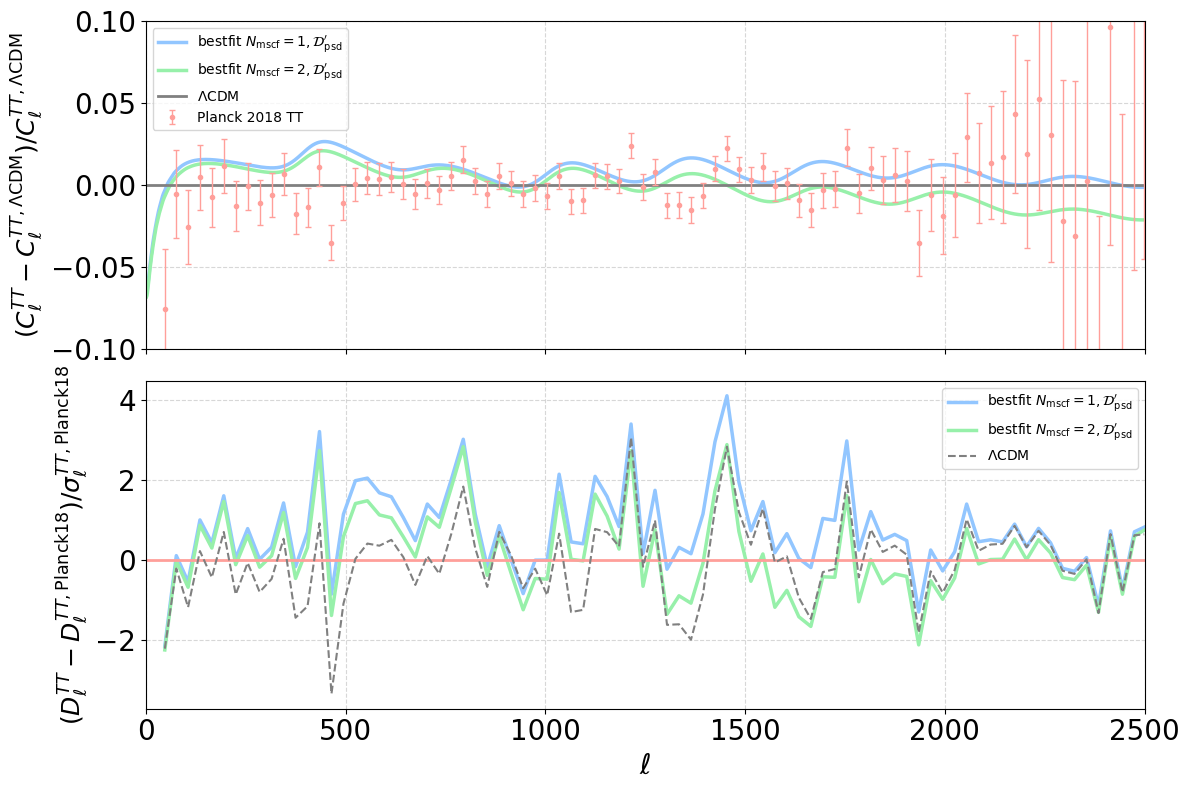

Saved bf_residuals.pdf to /Users/bellamarco01/uni/1_master_thesis/thesis/plots


In [59]:
import plotting.plotting as pl

# fig,axs = pl.new_fig(figsize=[7,10],nrows=2,ncols=1)
fig, axs = pl.new_fig(nrows=2, ncols=1, figsize=(12,8), sharey=False)
names = [r'$N_\text{mscf}=1, \mathcal{D}^\prime_\text{pd}$',r'$N_\text{mscf}=1, \mathcal{D}^\prime_\text{psd}$',r'$N_\text{mscf}=2, \mathcal{D}^\prime_\text{pd}$',r'$N_\text{mscf}=2, \mathcal{D}^\prime_\text{psd}$',]


for i in [1,3]:
    residuals_bf = residuals_bf_all[i]
    # sigma = (upper_68_all[i] - lower_68_all[i] )/ 2
    # build interpolator
    # res_interp = interp1d(
    #     ell,
    #     residuals_bf,
    #     kind='linear',
    #     bounds_error=False,
    #     fill_value='extrapolate'
    # )

    delta = (Dl_err_minus + Dl_err_plus)/2

    # evaluate at Planck ell's
    residuals_bf_int = bf_vs_planck_all[i]

    # residuals = (Dl_0 - Dl )/ Dl_0


    axs[0].plot(ell, residuals_bf, linewidth=2.5, label='bestfit '+names[i])
    axs[1].plot(ell_data, residuals_bf_int/delta, linewidth=2.5, label='bestfit '+names[i])

axs[0].axhline(y=0, linewidth=2, label='$\Lambda$CDM', color='grey')
from plotting.plotting import COLORS
axs[1].axhline(y=0, linewidth=2, color=COLORS[2])
axs[0].errorbar(
    ell_data, residuals,
    yerr=Dl_err/Dl_0,
    fmt='o',
    markersize=3,
    elinewidth=1,
    capsize=2,
    label='Planck 2018 TT',
#     color = 'grey'
)
for ax in axs:
    # plt.xlabel(r"$\ell$")
    # plt.ylabel(r"$D_\ell^{TT}$ [$\mu K^2$]")
    ax.set_xlim(0, 2500)
    # ax.set_ylim(-0.05,0.05)

axs[1].plot(
    ell_data, residuals*Dl/Dl_err, linestyle='--',
    label='$\Lambda$CDM', color='grey'
)
# axs[0].set_ylim(-0.05,0.05)
# axs[1].set_ylim(-1,1)
axs[0].set_ylim(-0.1,0.1)
# axs[1].set_ylim(-3,7)

axs[1].set_xlabel(r"$\ell$",fontsize=20)
axs[0].set_ylabel(r"$(C_\ell^{TT} - C_\ell^{TT,\Lambda\text{CDM}})/ C_\ell^{TT,\Lambda\text{CDM}}$",fontsize=18)
axs[1].set_ylabel(r"$(D_\ell^{TT} - D_\ell^{TT,\text{Planck18}}) / \sigma_\ell^{TT,\text{Planck18}}$",fontsize=18)
# plt.title("2psd CMB TT Residuals")
# plt.ylim(0,0.1)
axs[0].legend()
axs[1].legend()
plt.tight_layout()
plt.show()
fig.save("bf_residuals")

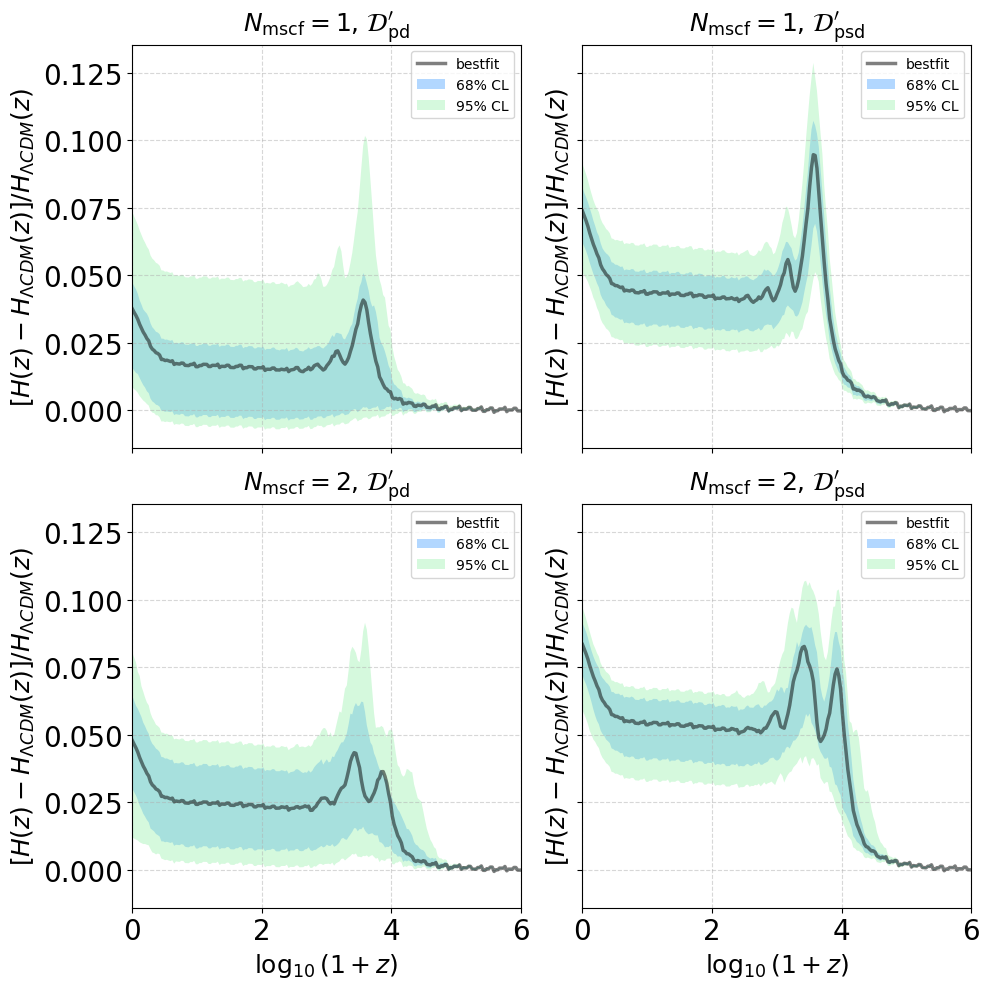

Saved 12pdpsdh.pdf to /Users/bellamarco01/uni/1_master_thesis/thesis/plots


In [68]:
import numpy as np
import plotting.plotting as pl

# create figure with 2x2 subplots
fig, axs = pl.new_fig(figsize=[10,10], nrows=2, ncols=2)

# titles for each subplot
titles = [
    r'$N_\text{mscf}=1$, $\mathcal{D}_\text{pd}^\prime$',
    r'$N_\text{mscf}=1$, $\mathcal{D}_\text{psd}^\prime$',
    r'$N_\text{mscf}=2$, $\mathcal{D}_\text{pd}^\prime$',
    r'$N_\text{mscf}=2$, $\mathcal{D}_\text{psd}^\prime$'
]

# loop over subplots and your stored data arrays
for i, ax in enumerate(axs):
    # bestfit plot
    ax.plot(np.log10(1 + z_bf_all[i]), residuals_bf_H_all[i],
            color='black', alpha=0.5, lw=2.5, label="bestfit")
    
    # 68% confidence interval
    ax.fill_between(np.log10(1 + zd_all[i][0]),
                    ci_h_all[i][1], ci_h_all[i][2],
                    alpha=0.7, label="68% CL")
    
    # 95% confidence interval
    ax.fill_between(np.log10(1 + zd_all[i][0]),
                    ci_h_all[i][0], ci_h_all[i][3],
                    alpha=0.4, label="95% CL")
    
    ax.set_title(titles[i], fontsize=18)
    ax.set_xlim(0,6)
    ax.set_ylabel(r"$[H(z)-H_{\Lambda CDM}(z)]/H_{\Lambda CDM}(z)$", fontsize=18)
    ax.legend()

# set x-labels for bottom row
axs[2].set_xlabel(r"$\log_{10}(1+z)$", fontsize=18)
axs[3].set_xlabel(r"$\log_{10}(1+z)$", fontsize=18)

plt.grid(True)
plt.tight_layout()
plt.show()
fig.save("12pdpsdh")


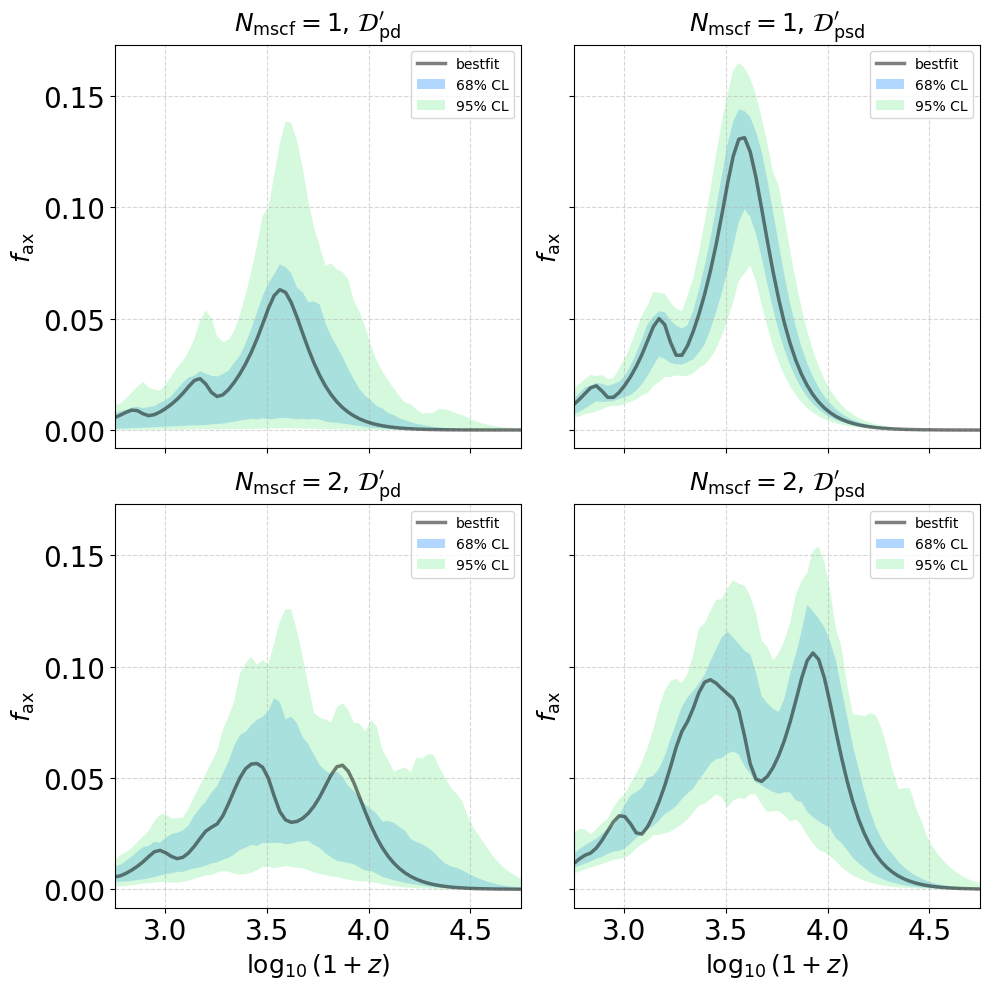

Saved 12pdpsd_fede.pdf to /Users/bellamarco01/uni/1_master_thesis/thesis/plots


In [69]:
import numpy as np
import plotting.plotting as pl

# figure 2x2
fig, axs = pl.new_fig(figsize=[10,10], nrows=2, ncols=2)

# titles for each subplot
titles = [
    r'$N_\text{mscf}=1$, $\mathcal{D}_\text{pd}^\prime$',
    r'$N_\text{mscf}=1$, $\mathcal{D}_\text{psd}^\prime$',
    r'$N_\text{mscf}=2$, $\mathcal{D}_\text{pd}^\prime$',
    r'$N_\text{mscf}=2$, $\mathcal{D}_\text{psd}^\prime$'
]

# loop over subplots and arrays
for i, ax in enumerate(axs):
    z_bf = z_bf_all[i]
    f_ede = f_ede_all[i]
    ci_fede = ci_fede_all[i]
    all_z = zd_all[i]  # same zd_all used for x-axis
    
    # plot bestfit
    ax.plot(np.log10(1 + z_bf), f_ede,
            color='black', alpha=0.5, lw=2.5, label="bestfit")
    
    # 68% confidence interval
    ax.fill_between(np.log10(1 + all_z[0]),
                    ci_fede[1], ci_fede[2],
                    alpha=0.7, label="68% CL")
    
    # 95% confidence interval
    ax.fill_between(np.log10(1 + all_z[0]),
                    ci_fede[0], ci_fede[3],
                    alpha=0.4, label="95% CL")
    
    ax.set_title(titles[i], fontsize=18)
    ax.set_xlim(0,6)
    ax.legend()

axs[0].set_ylabel(r"$f_\text{ax}$", fontsize=18)
axs[2].set_ylabel(r"$f_\text{ax}$", fontsize=18)
# bottom row x-labels
axs[2].set_xlabel(r"$\log_{10}(1+z)$", fontsize=18)
axs[3].set_xlabel(r"$\log_{10}(1+z)$", fontsize=18)

plt.xlabel(r"$\log_{10}(1+z)$", fontsize=18)
plt.xlim(2.75,4.75)
plt.grid(True)
plt.tight_layout()
plt.show()
fig.save("12pdpsd_fede")


In [ ]:
bf_z = []
bf_fEDE = []
bf_H =[]
bf_ell = []
bf_cl_tt = []

data = np.load("/Users/bellamarco01/uni/1_master_thesis/tools/output_remote/mini_reconstruction_tool/1pd/output_class/bestfit.npz")
bf_z= (data["z"])
bf_fEDE= (data["f_EDE"])
bf_H= (data["H"])
bf_ell= (data["ell"])
bf_cl_tt= (data["cl_tt"])

plt.plot(bf_ell[500:], bf_cl_tt[500:], label='1 axion bestfilt Cl')
plt.plot(ell[500:], cl_tt_0[500:], label='lcdm bestfit cl')
plt.legend()
# plt.yscale('log')
